# Base Length Correction

# 1. Settings

## 1.1. Import modules

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

## 1.2. Hyperparameters

In [2]:
# Data
# Reference
DATA_DIRECTORY = os.path.join("..", "data")
DOCUMENT_DIRECTORY = os.path.join("..", "docs")
DATASET_NAME = "BCA-200uL-2"
REFERENCE_FILE = f"reference_{DATASET_NAME}.csv"
BASE_LENGTH_REFERENCE_FILE = "base_length.csv"

# Prediction
SAMPLE_NAME = "powder"
DATASET_NAME = "BCA-1"
PREDICTIONS_DIRECTORY = os.path.join(DATA_DIRECTORY, "predictions")
PREDICTION_FILE = f"prediction_{SAMPLE_NAME}_{DATASET_NAME}.csv"
TESTS_DIRECTORY = os.path.join(DATA_DIRECTORY, "tests")
TEST_FILE = f"test_{SAMPLE_NAME}_{DATASET_NAME}.csv"

COLOR_SPACE_NAME = "hsv"
MODEL_NAME = "random_forest"
MODEL_NAME = f'{MODEL_NAME}_{COLOR_SPACE_NAME}.joblib'

# Plot
NAME_OF_LABEL = "Protein Concentration"
LABEL_UNIT = "\u03BCg/mL"
TITLE_FONT = {'fontname':'Times New Roman', 'size':'16', 'color':'black', 'weight':'heavy'}
AXIS_FONT = {'fontname':'Times New Roman', 'size':'12', 'weight':'heavy'}
LEGEND_FONT = {'family': 'Times New Roman', 'size': 12}
TITLE_DISPLAY = True
FIGURE_SIZE = (5, 5)
SAVE_FIGURE = True

## 1.3. Define functions

### 1.3.1. Save figure

In [3]:
# Define a function to save figure
def save_fig(fig, fig_name, dataset_name, docs_dir):
    try:
        # Create /docs directory if doesn't exist
        if not os.path.exists(docs_dir):
            os.makedirs(docs_dir)
            print(f"Document directory is created at: {docs_dir}")
        
        # Create /dataset document directory if doesn't exist
        dataset_docs_dir = os.path.join(docs_dir, dataset_name)
        if not os.path.exists(dataset_docs_dir):
            os.makedirs(dataset_docs_dir)
            print(f"{dataset_name} directory is created at: {dataset_docs_dir}")

        # Save the figure
        fig_file = os.path.join(dataset_docs_dir, f"{fig_name}_{dataset_name}.png")
        fig.savefig(fig_file, dpi=300)
        print(f"Figure saved at: {os.path.abspath(fig_file)}")

    except Exception as e:
        print("Saving figure error occurred: {e}")

### 1.3.2. Load calibration file

In [4]:
# Define a function to load sensor calibration data
def load_calibration_data(calibration_data, data_dir):
    # Define the calibration data path
    calibration_data_path = os.path.join(data_dir, calibration_data)
    
    # Check if the data file exists
    if not os.path.exists(calibration_data_path):
        print(f"No calibration data found at: {os.path.abspath(calibration_data_path)}")
        return None, None

    # Load the global_min and global_max data
    try:
        with open(calibration_data_path, 'r') as file:
            lines = file.readlines()
            global_min = [float(val) for val in lines[0].split(":")[1].strip()[1:-1].split(", ")]
            global_max = [float(val) for val in lines[1].split(":")[1].strip()[1:-1].split(", ")]
        print(f"Calibration data loaded from: {os.path.abspath(calibration_data_path)}")
    except Exception as e:
        print(f"Calibration data load error occurred: {e}")
        return None, None

    return global_min, global_max

### 1.3.3. Convert RGB-Frequency to RGB

In [5]:
# Gamma Correction
def gamma_correction(channel, gamma=1):
    return 255 * (channel / 255.0) ** (1/gamma)

# Method to read color in RGB format calibrated with the data
def freq_to_rgb(freq, global_min, global_max, gamma=1):
    # Normalize frequency values for RGB to [0, 255]
    colors = ['RED', 'GREEN', 'BLUE']
    for i, color in enumerate(colors):
        # Normalize to [0, 255] range
        if freq[color] < global_min[i]:
            freq[color] = 0
        elif freq[color] > global_max[i]:
            freq[color] = 255
        else:
            freq[color] = (freq[color] - global_min[i]) / (global_max[i] - global_min[i]) * 255

    #Apply Gamma Correction
    rgb = {}
    for color in colors:
        rgb[color] = gamma_correction(freq[color], gamma)
    freq = rgb

    return freq

### 1.3.4. Convert RGB to other color spaces

In [6]:
# Method to convert RGB to CMYK
def rgb_to_cmyk(r, g, b):
    # Normalize RGB values
    r = r / 255.0
    g = g / 255.0
    b = b / 255.0

    # Convert RGB to CMYK
    # Black
    k = 1 - max(r, g, b)

    # Cyan
    c = (1 - r - k) / (1 - k) if k != 1 else 0

    # Magenta
    m = (1 - g - k) / (1 - k) if k != 1 else 0

    # Yellow
    y = (1 - b - k) / (1 - k) if k != 1 else 0

    # Return CMYK color
    return c, m, y, k

# Method to convert CMYK to RGB
def cmyk_to_rgb(c, m, y, k):
    # Convert CMYK to RGB
    r = 255 * (1-c) * (1-k)
    g = 255 * (1-m) * (1-k)
    b = 255 * (1-y) * (1-k)

    # Ensure r, g, b are within the valid range [0, 255]
    r = min(max(0, r), 255)
    g = min(max(0, g), 255)
    b = min(max(0, b), 255)

    return int(r), int(g), int(b)

# Method to convert RGB to HSL
def rgb_to_hsl(r, g, b):
        r /= 255
        g /= 255
        b /= 255
        max_val = max(r, g, b)
        min_val = min(r, g, b)
        diff = max_val - min_val
        h = s = l = (max_val + min_val) / 2

        if max_val == min_val:
            h = s = 0  # achromatic
        else:
            # saturation calculation
            if l > 0.5:
                s = diff / (2 - max_val - min_val)
            else:
                s = diff / (max_val + min_val)
            
            # hue calculation
            if max_val == r:
                h = (g - b) / diff + (g < b) * 6
            elif max_val == g:
                h = (b - r) / diff + 2
            else:
                h = (r - g) / diff + 4

            h /= 6

        return h, s, l

# Method to convert HSL to RGB
def hsl_to_rgb(h, s, l):
    if s == 0:
        r = g = b = l  # achromatic
    else:
        def hue_to_rgb(p, q, t):
            if t < 0:
                t += 1
            if t > 1:
                t -= 1
            if t < 1 / 6:
                return p + (q - p) * 6 * t
            if t < 1 / 2:
                return q
            if t < 2 / 3:
                return p + (q - p) * (2 / 3 - t) * 6
            return p

        q = l < 0.5 and l * (1 + s) or l + s - l * s
        p = 2 * l - q
        r = hue_to_rgb(p, q, h + 1 / 3)
        g = hue_to_rgb(p, q, h)
        b = hue_to_rgb(p, q, h - 1 / 3)

    return int(r * 255), int(g * 255), int(b * 255)

# Method to convert RGB to HSV
def rgb_to_hsv(r, g, b):
    r /= 255.0
    g /= 255.0
    b /= 255.0
    
    max_val = max(r, g, b)
    min_val = min(r, g, b)
    diff = max_val - min_val
    
    if max_val == min_val:
        h = 0
    elif max_val == r:
        h = ((60 * ((g-b)/diff) + 360) % 360) / 360.0
    elif max_val == g:
        h = ((60 * ((b-r)/diff) + 120) % 360) / 360.0
    elif max_val == b:
        h = ((60 * ((r-g)/diff) + 240) % 360) / 360.0

    if max_val == 0:
        s = 0
    else:
        s = diff/max_val

    v = max_val

    return h, s, v

# Method to convert HSV to RGB
def hsv_to_rgb(h, s, v):
    # When saturation is 0, the color is a shade of gray
    if s == 0:
        r = g = b = v
        return r, g, b

    # Find which sector of the color circle the hue is in
    sector = h * 6.0
    i = int(sector)
    f = sector - i

    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    if i == 0:
        r, g, b = v, t, p
    elif i == 1:
        r, g, b = q, v, p
    elif i == 2:
        r, g, b = p, v, t
    elif i == 3:
        r, g, b = p, q, v
    elif i == 4:
        r, g, b = t, p, v
    else:
        r, g, b = v, p, q

    return int(r * 255), int(g * 255), int(b * 255)

# Method to convert RGB to CIELAB
def rgb_to_lab(r, g, b):
    # Gamma correction
    rgb = [c / 255.0 for c in [r, g, b]]
    for i in range(3):
        if rgb[i] <= 0.04045:
            rgb[i] /= 12.92
        else:
            rgb[i] = ((rgb[i] + 0.055) / 1.055) ** 2.4

    # RGB to CIEXYZ
    X = 0.4124 * rgb[0] + 0.3576 * rgb[1] + 0.1805 * rgb[2]
    Y = 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]
    Z = 0.0193 * rgb[0] + 0.1192 * rgb[1] + 0.9505 * rgb[2]

    # Normalize for D65 illuminant
    X /= 0.95047
    Y /= 1.00000
    Z /= 1.08883

    X_trans = X ** (1/3) if X > 0.008856 else 7.787 * X + 16/116
    Y_trans = Y ** (1/3) if Y > 0.008856 else 7.787 * Y + 16/116
    Z_trans = Z ** (1/3) if Z > 0.008856 else 7.787 * Z + 16/116

    L = 116.0 * Y_trans - 16.0
    a = 500.0 * (X_trans - Y_trans)
    b = 200.0 * (Y_trans - Z_trans)

    return L, a, b

# Method to convert CIELAB to RGB
def lab_to_rgb(L, a, b):
    # CIELAB to CIEXYZ
    Y = (L + 16) / 116
    X = a / 500 + Y
    Z = Y - b / 200
    
    if Y**3 > 0.008856:
        Y = Y**3
    else:
        Y = (Y - 16/116) / 7.787
    
    if X**3 > 0.008856:
        X = X**3
    else:
        X = (X - 16/116) / 7.787
        
    if Z**3 > 0.008856:
        Z = Z**3
    else:
        Z = (Z - 16/116) / 7.787
        
    # D65 illuminant
    X = X * 0.95047
    Y = Y * 1.00000
    Z = Z * 1.08883
    
    # CIEXYZ to linear RGB
    r = X *  3.2406 + Y * -1.5372 + Z * -0.4986
    g = X * -0.9689 + Y *  1.8758 + Z *  0.0415
    b = X *  0.0557 + Y * -0.2040 + Z *  1.0570
    
    # Apply gamma correction on linear RGB values
    if r > 0.0031308:
        r = 1.055 * (r**(1/2.4)) - 0.055
    else:
        r = 12.92 * r
        
    if g > 0.0031308:
        g = 1.055 * (g**(1/2.4)) - 0.055
    else:
        g = 12.92 * g
        
    if b > 0.0031308:
        b = 1.055 * (b**(1/2.4)) - 0.055
    else:
        b = 12.92 * b
        
    # Convert these values to the range [0, 255]
    r = min(max(int(r * 255), 0), 255)
    g = min(max(int(g * 255), 0), 255)
    b = min(max(int(b * 255), 0), 255)

    return r, g, b

# Define a function to select color conversion
def convert_color_space(rgb, color_space_name='rgb'):
    r, g, b = [rgb['RED'], rgb['GREEN'], rgb['BLUE']]

    try:
        # Convert color space
        if color_space_name == 'rgb':
            return r, g, b
        elif color_space_name == 'cmyk':
            return rgb_to_cmyk(r, g, b)
        elif color_space_name == 'hsl':
            return rgb_to_hsl(r, g, b)
        elif color_space_name == 'hsv':
            return rgb_to_hsv(r, g, b)
        elif color_space_name == 'lab':
            return rgb_to_lab(r, g, b)
    
    except Exception as e:
        print(f"Conversion of color error occurred: {e}")
        return

### 1.3.5. Load prediction model

In [7]:
# Define a function to load pre-trained model
def load_model(model_name, data_dir):
    # Define the model path
    model_path = os.path.join(data_dir, "models", model_name)
    
    # Check if the model exists
    if not os.path.exists(model_path):
        raise(f"No model found at: {os.path.abspath(model_path)}")

    # Load the model
    try:
        model = joblib.load(model_path)
        print(f"Model loaded from: {os.path.abspath(model_path)}")
    except Exception as e:
        print("Model load error occurred: {e}")

    return model

# 2. Base length data

## 2.1. Clear frequency

In [8]:
# Read data from CSV into base_length_df
base_length_df = pd.read_csv(os.path.join(DATA_DIRECTORY, BASE_LENGTH_REFERENCE_FILE))

# Group by 'Label' and calculate mean and std of 'Clear_Frequency'
base_length_clear_calibration_df = base_length_df.groupby('Label')['Clear_Frequency'].agg(['mean', 'std'])

# Calculate CV (Coefficient of Variation) as std / mean
base_length_clear_calibration_df['CV'] = base_length_clear_calibration_df['std'] / base_length_clear_calibration_df['mean']

# Calculate Normalized Mean (divide by the maximum mean)
max_mean = base_length_clear_calibration_df['mean'].max()
base_length_clear_calibration_df['Normalized_Mean'] = base_length_clear_calibration_df['mean'] / max_mean

# Reset the index so 'Label' becomes a column
base_length_clear_calibration_df.reset_index(inplace=True)

# Add a column for the alphabet corresponding to the 'Label'
# Assuming 1.0 maps to 'A', 2.0 to 'B', etc.
base_length_clear_calibration_df['Row'] = base_length_clear_calibration_df['Label'].apply(lambda x: chr(int(x) + 64))

In [9]:
base_length_clear_calibration_df.head(10)

,Label,mean,std,CV,Normalized_Mean,Row
0,1.0,31611.139968,171.036499,0.005411,0.904177,A
1,2.0,34849.531907,298.802610,0.008574,0.996805,B
2,3.0,32748.809456,1058.071221,0.032309,0.936718,C
3,4.0,34961.225301,399.300918,0.011421,1.000000,D
4,5.0,34697.746463,243.284903,0.007012,0.992464,E
5,6.0,32126.968012,144.656937,0.004503,0.918931,F
6,7.0,29777.508316,269.126792,0.009038,0.851730,G
7,8.0,26811.252609,224.369761,0.008368,0.766885,H


## 2.2. RGB sum

In [10]:
# Calculate the sum of Red, Green, and Blue frequencies for each row
base_length_df['Sum_RGB_Frequencies'] = base_length_df['Red_Frequency'] + base_length_df['Green_Frequency'] + base_length_df['Blue_Frequency']

# Group by 'Label' and calculate mean and std of 'Sum_RGB_Frequencies'
base_length_rgb_calibration_df = base_length_df.groupby('Label')['Sum_RGB_Frequencies'].agg(['mean', 'std'])

# Calculate CV (Coefficient of Variation) as std / mean
base_length_rgb_calibration_df['CV'] = base_length_rgb_calibration_df['std'] / base_length_rgb_calibration_df['mean']

# Calculate Normalized Mean (divide by the maximum mean)
max_mean = base_length_rgb_calibration_df['mean'].max()
base_length_rgb_calibration_df['Normalized_RGB_Mean'] = base_length_rgb_calibration_df['mean'] / max_mean

# Reset the index so 'Label' becomes a column
base_length_rgb_calibration_df.reset_index(inplace=True)

# Add a column for the alphabet corresponding to the 'Label'
# Assuming 1.0 maps to 'A', 2.0 to 'B', etc.
base_length_rgb_calibration_df['Row'] = base_length_rgb_calibration_df['Label'].apply(lambda x: chr(int(x) + 64))

In [11]:
base_length_rgb_calibration_df.head(10)

,Label,mean,std,CV,Normalized_RGB_Mean,Row
0,1.0,65067.479851,519.491642,0.007984,0.835841,A
1,2.0,76088.358229,210.517754,0.002767,0.977413,B
2,3.0,77846.682795,302.797281,0.003890,1.000000,C
3,4.0,75873.606038,405.714481,0.005347,0.974654,D
4,5.0,71794.878300,520.255347,0.007246,0.922260,E
5,6.0,66255.148962,313.976615,0.004739,0.851098,F
6,7.0,61264.519044,679.857521,0.011097,0.786989,G
7,8.0,54979.853338,296.943924,0.005401,0.706258,H


# 3. Training Data

## 3.1. Load training data

In [12]:
# Read reference data
reference_df = pd.read_csv(os.path.join(DATA_DIRECTORY, REFERENCE_FILE))

# Define the mapping function for the row letter based on the Label
def label_to_row(label):
    return chr(((int(label) // 4) % 6) + ord('B'))

# Add the 'Row' column to reference_df
reference_df['Row'] = reference_df['Label'].apply(label_to_row)

# Initialize 'Normalized_Mean' in reference_df with NaN
reference_df['Normalized_Mean'] = np.nan
reference_df['Normalized_RGB_Mean'] = np.nan

# Iterate through rows of reference_df
for idx, row in reference_df.iterrows():
    row_value = row['Row']
    clear_query_result = base_length_clear_calibration_df.query(f"Row == '{row_value}'")
    rgb_query_result = base_length_rgb_calibration_df.query(f"Row == '{row_value}'")
    
    if not clear_query_result.empty:
        reference_df.loc[idx, 'Normalized_Mean'] = clear_query_result['Normalized_Mean'].values[0]
    
    if not rgb_query_result.empty:
        reference_df.loc[idx, 'Normalized_RGB_Mean'] = rgb_query_result['Normalized_RGB_Mean'].values[0]

In [13]:
reference_df.head()

,Red_Frequency,Green_Frequency,Blue_Frequency,Clear_Frequency,Red,Green,Blue,Label,Row,Normalized_Mean,Normalized_RGB_Mean
0,24530.19442,19994.10407,19452.84920,30988.68075,248.876086,250.587482,254.693336,0.0,B,0.996805,0.977413
1,24585.20976,19514.63727,19675.86634,30921.48255,251.660511,242.327536,255.000000,4.0,C,0.936718,1.000000
2,22771.55549,17695.63638,18447.29550,28372.97836,222.545828,210.765716,235.168750,8.0,D,1.000000,0.974654
3,21032.55807,16055.15637,17213.04737,26126.34705,198.602758,182.307098,212.820257,12.0,E,0.992464,0.922260
4,18739.04105,14004.00945,15452.64226,23225.37078,162.829256,146.273141,179.037518,16.0,F,0.918931,0.851098


## 3.2. Visualize training data

In [14]:
COLORIMETRY_SYSTEM = "rgbc-freq"
SAVE_FIGURE = True


In [15]:
# Create the dictionary
reference = {(r['Red'], r['Green'], r['Blue']): r['Label'] for _, r in reference_df.iterrows()}
# Normalize RGB for coloring
colors = [(k[0]/255, k[1]/255, k[2]/255) for k in reference.keys()]
# Prepare Label values
labels = list(reference.values())

# Create the dictionary for frequencies
frequencies = {(r['Red_Frequency'], r['Green_Frequency'], r['Blue_Frequency'], r['Clear_Frequency']): r['Label'] for _, r in reference_df.iterrows()}

# Extract the values for each frequency using a list comprehension
red_frequencies = [k[0] for k in frequencies.keys()]
green_frequencies = [k[1] for k in frequencies.keys()]
blue_frequencies = [k[2] for k in frequencies.keys()]
clear_frequencies = [k[3] for k in frequencies.keys()]

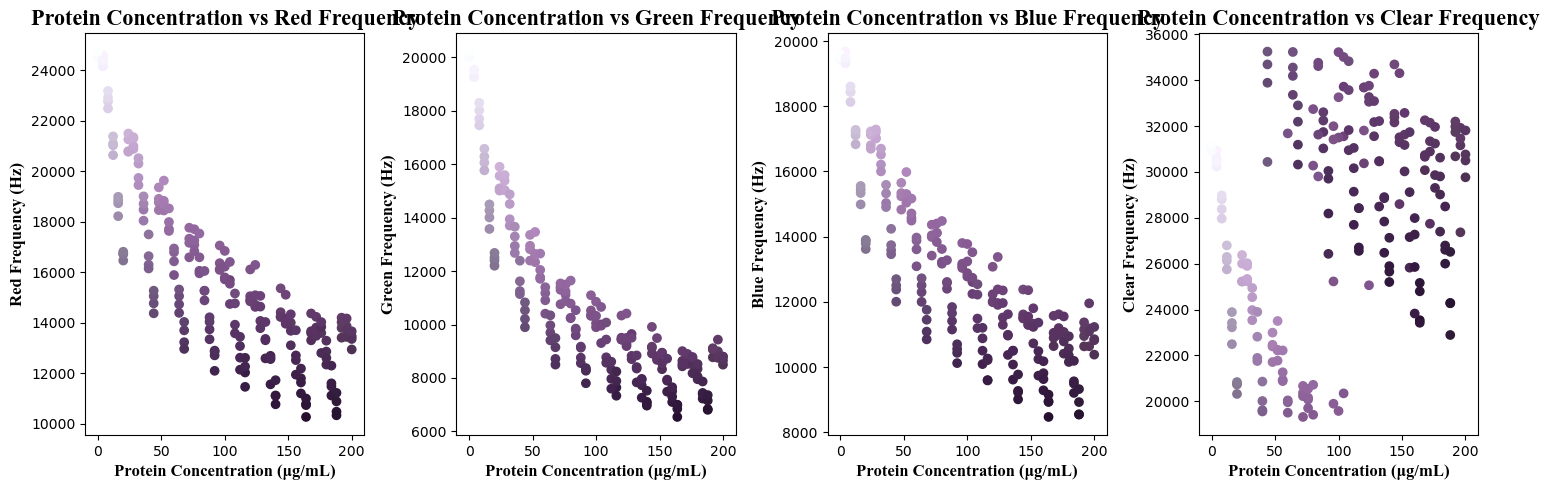

Figure saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\docs\BCA-1\Each_Frequency_of_Dataset_rgbc-freq_BCA-1.png


In [16]:
# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(FIGURE_SIZE[0]*3, FIGURE_SIZE[1]))

# Names for each subplot
freq_names = ['Red Frequency', 'Green Frequency', 'Blue Frequency', 'Clear Frequency']

# Plot Label vs Frequencies
for idx, freq_name in enumerate(freq_names):
    axs[idx].scatter(labels, [k[idx] for k in frequencies.keys()], color=colors)
    axs[idx].set_xlabel(f"{NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)
    axs[idx].set_ylabel(f"{freq_name} (Hz)", **AXIS_FONT)
    if TITLE_DISPLAY == True:
        axs[idx].set_title(f'{NAME_OF_LABEL} vs {freq_name}', **TITLE_FONT)

# Display the plots
plt.tight_layout()
plt.show()

# Save figure
if SAVE_FIGURE == True:
    save_fig(fig, f"Each_Frequency_of_Dataset_{COLORIMETRY_SYSTEM}", DATASET_NAME, DOCUMENT_DIRECTORY)

## 3.3. Using clear frequency

### 3.3.1. Base length correction

In [17]:
# Load calibration data to get maximum and minimum frequencies
global_min, global_max = load_calibration_data("calibration.txt", DATA_DIRECTORY)

reference_clear_corrected_df = pd.DataFrame(columns=[
    'Row',
    'Red_Frequency',
    'Green_Frequency',
    'Blue_Frequency',
    'Clear_Frequency',
    'Normalized_Mean',
    'Red',
    'Green',
    'Blue',
    'Label'
    ])

# Iterate through rows of reference_df
for idx, row in reference_df.iterrows():
    red_frac = row['Red_Frequency'] / row['Normalized_Mean']
    green_frac = row['Green_Frequency'] / row['Normalized_Mean']
    blue_frac = row['Blue_Frequency'] / row['Normalized_Mean']
    clear_frac = row['Clear_Frequency'] / row['Normalized_Mean']

    rgb = freq_to_rgb({'RED': red_frac, 'GREEN': green_frac, 'BLUE': blue_frac}, global_min, global_max)
    
    temp_df = pd.DataFrame({
        "Row": row['Row'],
        "Red_Frequency": [red_frac],
        "Green_Frequency": [green_frac],
        "Blue_Frequency": [blue_frac],
        "Clear_Frequency": [clear_frac],
        "Normalized_Mean": [row['Normalized_Mean']],
        "Red": [rgb['RED']],
        "Green": [rgb['GREEN']],
        "Blue": [rgb['BLUE']],
        "Label": [float(row['Label'])]
    })

    reference_clear_corrected_df = pd.concat([reference_clear_corrected_df, temp_df])

Calibration data loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\calibration.txt


In [18]:
reference_clear_corrected_df.head()

,Row,Red_Frequency,Green_Frequency,Blue_Frequency,Clear_Frequency,Normalized_Mean,Red,Green,Blue,Label
0,B,24608.814146,20058.185543,19515.195941,31088.000044,0.996805,251.054194,252.682080,255.000000,0.0
0,C,26246.116172,20832.990316,21005.111561,33010.449419,0.936718,255.000000,255.000000,255.000000,4.0
0,D,22771.555490,17695.636380,18447.295500,28372.978360,1.000000,223.723710,211.173858,236.399534,8.0
0,E,21192.269709,16177.071894,17343.755389,26324.738596,0.992464,200.230749,184.493816,215.477425,12.0
0,F,20392.208684,15239.450213,16815.882138,25274.324681,0.918931,188.329292,168.020504,205.469432,16.0


### 3.3.2. Visualize corrected data

In [19]:
COLORIMETRY_SYSTEM = "rgbc-freq"
SAVE_DATAFRAME = False
SAVE_FIGURE = True

In [20]:
# Create the dictionary
reference = {((r['Red'], r['Green'], r['Blue']), r['Clear_Frequency']): r['Label'] for _, r in reference_clear_corrected_df.iterrows()}
# Normalize RGB for coloring
colors = [(k[0][0]/255, k[0][1]/255, k[0][2]/255) for k in reference.keys()]
# Prepare Label values
labels = list(reference.values())

# Create the dictionary for frequencies
frequencies = {(r['Red_Frequency'], r['Green_Frequency'], r['Blue_Frequency'], r['Clear_Frequency']): r['Label'] for _, r in reference_clear_corrected_df.iterrows()}

# Extract the values for each frequency using a list comprehension
red_frequencies = [k[0] for k in frequencies.keys()]
green_frequencies = [k[1] for k in frequencies.keys()]
blue_frequencies = [k[2] for k in frequencies.keys()]
clear_frequencies = [k[3] for k in frequencies.keys()]
clear_frequencies = [k[3] for k in frequencies.keys()]

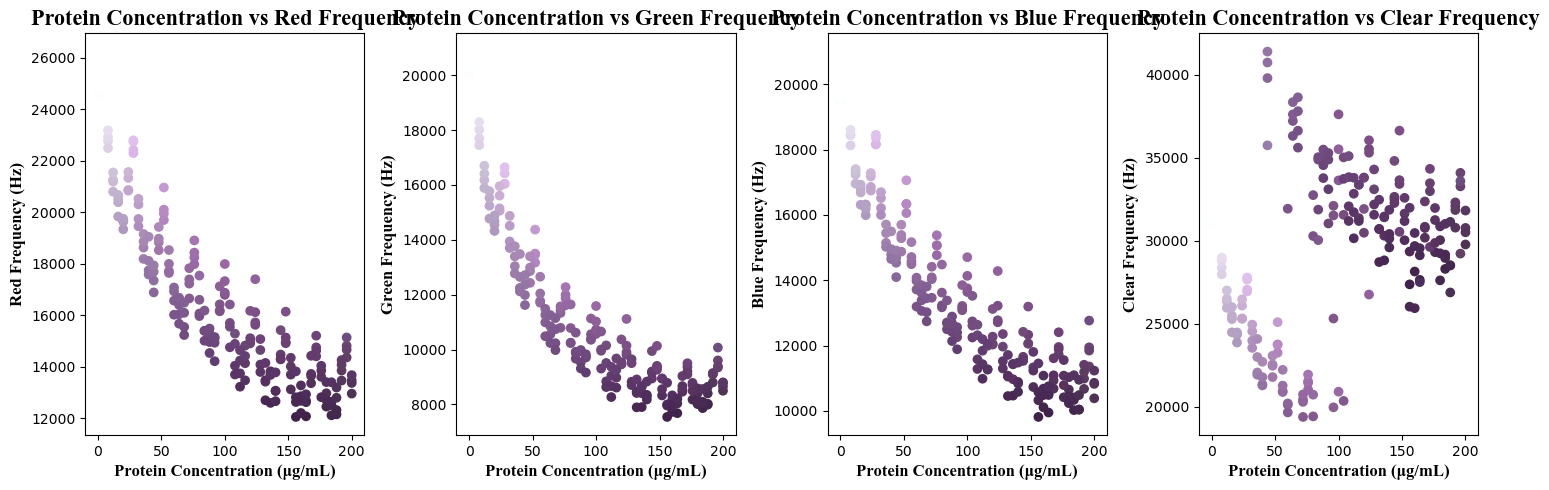

Figure saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\docs\BCA-1\Clear-corrected_Dataset_rgbc-freq_BCA-1.png


In [21]:
# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(FIGURE_SIZE[0]*3, FIGURE_SIZE[1]))

# Names for each subplot
freq_names = ['Red Frequency', 'Green Frequency', 'Blue Frequency', 'Clear Frequency']

# Plot Label vs Frequencies
for idx, freq_name in enumerate(freq_names):
    axs[idx].scatter(labels, [k[idx] for k in frequencies.keys()], color=colors)
    axs[idx].set_xlabel(f"{NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)
    axs[idx].set_ylabel(f"{freq_name} (Hz)", **AXIS_FONT)
    if TITLE_DISPLAY == True:
        axs[idx].set_title(f'{NAME_OF_LABEL} vs {freq_name}', **TITLE_FONT)

# Display the plots
plt.tight_layout()
plt.show()

# Save figure
if SAVE_FIGURE == True:
    save_fig(fig, f"Clear-corrected_Dataset_{COLORIMETRY_SYSTEM}", DATASET_NAME, DOCUMENT_DIRECTORY)

In [22]:
if SAVE_DATAFRAME == True:
    reference_rgb_corrected_df.to_csv(os.path.join(DATA_DIRECTORY, f'reference_corrected_{DATASET_NAME}.csv'), index=False)

## 3.4. Using RGB sum

### 3.4.1. Base length correction

In [23]:
# Load calibration data to get maximum and minimum frequencies
global_min, global_max = load_calibration_data("calibration.txt", DATA_DIRECTORY)

reference_rgb_corrected_df = pd.DataFrame(columns=[
    'Row',
    'Red_Frequency',
    'Green_Frequency',
    'Blue_Frequency',
    'Clear_Frequency',
    'Normalized_RGB_Mean',
    'Red',
    'Green',
    'Blue',
    'Label'
    ])

# Iterate through rows of reference_df
for idx, row in reference_df.iterrows():
    red_frac = row['Red_Frequency'] / row['Normalized_RGB_Mean']
    green_frac = row['Green_Frequency'] / row['Normalized_RGB_Mean']
    blue_frac = row['Blue_Frequency'] / row['Normalized_RGB_Mean']
    clear_frac = row['Clear_Frequency'] / row['Normalized_RGB_Mean']
    rgb = freq_to_rgb({'RED': red_frac, 'GREEN': green_frac, 'BLUE': blue_frac}, global_min, global_max)
    
    temp_df = pd.DataFrame({
        "Row": row['Row'],
        "Red_Frequency": [red_frac],
        "Green_Frequency": [green_frac],
        "Blue_Frequency": [blue_frac],
        "Clear_Frequency": [clear_frac],
        "Normalized_RGB_Mean": [row['Normalized_RGB_Mean']],
        "Red": [rgb['RED']],
        "Green": [rgb['GREEN']],
        "Blue": [rgb['BLUE']],
        "Label": [float(row['Label'])]
    })

    reference_rgb_corrected_df = pd.concat([reference_rgb_corrected_df, temp_df])

Calibration data loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\calibration.txt


In [24]:
reference_rgb_corrected_df.head()

,Row,Red_Frequency,Green_Frequency,Blue_Frequency,Clear_Frequency,Normalized_RGB_Mean,Red,Green,Blue,Label
0,B,25097.062262,20456.147478,19902.384758,31704.797642,0.977413,255.000000,255.000000,255.000000,0.0
0,C,24585.209760,19514.637270,19675.866340,30921.482550,1.000000,250.703063,243.132344,255.000000,4.0
0,D,23363.724878,18155.807586,18927.013440,29110.811541,0.974654,232.532636,219.258722,245.494546,8.0
0,E,22805.455141,17408.493401,18663.986488,28328.614792,0.922260,224.227990,206.128971,240.507796,12.0
0,F,22017.491582,16454.052230,18156.127625,27288.717937,0.851098,212.506491,189.360153,230.879258,16.0


### 3.4.2. Visualize corrected data

In [25]:
COLORIMETRY_SYSTEM = "rgbc-freq"
SAVE_DATAFRAME = True
SAVE_FIGURE = True

In [26]:
# Create the dictionary
reference = {((r['Red'], r['Green'], r['Blue']), r['Clear_Frequency']): r['Label'] for _, r in reference_rgb_corrected_df.iterrows()}
# Normalize RGB for coloring
colors = [(k[0][0]/255, k[0][1]/255, k[0][2]/255) for k in reference.keys()]
# Prepare Label values
labels = list(reference.values())

# Create the dictionary for frequencies
frequencies = {(r['Red_Frequency'], r['Green_Frequency'], r['Blue_Frequency'], r['Clear_Frequency']): r['Label'] for _, r in reference_rgb_corrected_df.iterrows()}

# Extract the values for each frequency using a list comprehension
red_frequencies = [k[0] for k in frequencies.keys()]
green_frequencies = [k[1] for k in frequencies.keys()]
blue_frequencies = [k[2] for k in frequencies.keys()]
clear_frequencies = [k[3] for k in frequencies.keys()]

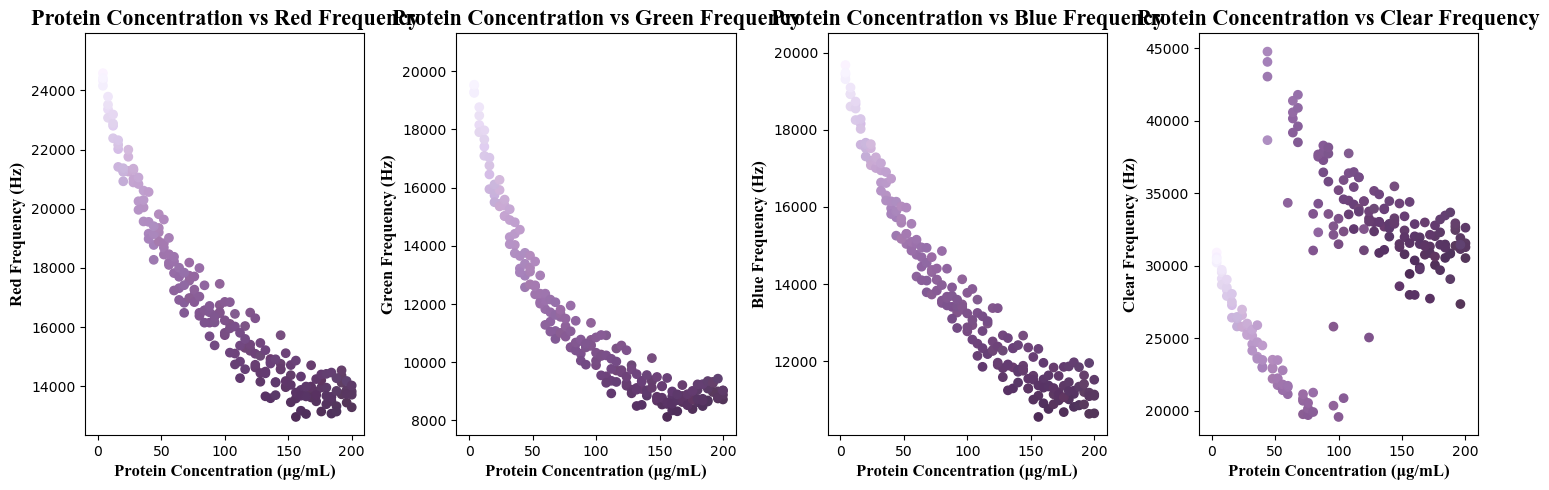

Figure saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\docs\BCA-1\RGB-corrected_Dataset_rgbc-freq_BCA-1.png


In [27]:
# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(FIGURE_SIZE[0]*3, FIGURE_SIZE[1]))

# Names for each subplot
freq_names = ['Red Frequency', 'Green Frequency', 'Blue Frequency', 'Clear Frequency']

# Plot Label vs Frequencies
for idx, freq_name in enumerate(freq_names):
    axs[idx].scatter(labels, [k[idx] for k in frequencies.keys()], color=colors)
    axs[idx].set_xlabel(f"{NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)
    axs[idx].set_ylabel(f"{freq_name} (Hz)", **AXIS_FONT)
    if TITLE_DISPLAY == True:
        axs[idx].set_title(f'{NAME_OF_LABEL} vs {freq_name}', **TITLE_FONT)

# Display the plots
plt.tight_layout()
plt.show()

# Save figure
if SAVE_FIGURE == True:
    save_fig(fig, f"RGB-corrected_Dataset_{COLORIMETRY_SYSTEM}", DATASET_NAME, DOCUMENT_DIRECTORY)

In [28]:
if SAVE_DATAFRAME == True:
    reference_rgb_corrected_df.to_csv(os.path.join(DATA_DIRECTORY, f'reference_corrected_{DATASET_NAME}.csv'), index=False)

# 4. Prediction Data

## 4.1. Load prediction data

In [29]:
prediction_df = pd.read_csv(os.path.join(PREDICTIONS_DIRECTORY, PREDICTION_FILE))

# Define the list of columns to be removed
cols_to_remove = ['Mean', 'STD', '%CV']

# Drop the columns if they exist
for col in cols_to_remove:
    if col in prediction_df.columns:
        prediction_df.drop(col, axis=1, inplace=True)

# Drop rows where 'Label_Name' is NaN
prediction_df = prediction_df.dropna(subset=['Label_Name'])

# Extract the 'Row' letter from 'Label_Name'
unexpected_format = prediction_df[~prediction_df['Label_Name'].str.match(r"\d+-[A-Z]\d")]
print(unexpected_format['Label_Name'])
prediction_df['Row'] = prediction_df['Label_Name'].apply(lambda x: x.split('-')[1][0])

# Initialize 'Normalized_Mean' and 'Normalized_RGB_Mean' in prediction_df with NaN
prediction_df['Normalized_Mean'] = np.nan
prediction_df['Normalized_RGB_Mean'] = np.nan

# Iterate through rows of prediction_df
for idx, row in prediction_df.iterrows():
    row_value = row['Row']
    
    clear_query_result = base_length_clear_calibration_df.query(f"Row == '{row_value}'")
    rgb_query_result = base_length_rgb_calibration_df.query(f"Row == '{row_value}'")
    
    if not clear_query_result.empty:
        prediction_df.loc[idx, 'Normalized_Mean'] = clear_query_result['Normalized_Mean'].values[0]
        
    if not rgb_query_result.empty:
        prediction_df.loc[idx, 'Normalized_RGB_Mean'] = rgb_query_result['Normalized_RGB_Mean'].values[0]

Series([], Name: Label_Name, dtype: object)


In [30]:
prediction_df.head()

,Label_Name,Red_Frequency,Green_Frequency,Blue_Frequency,Clear_Frequency,Red,Green,Blue,Row,Normalized_Mean,Normalized_RGB_Mean
0,1-A1,22185.53812,18268.24701,17641.68422,28260.54725,214.791818,221.912322,221.088874,A,0.904177,0.835841
1,1-A2,22420.73219,18475.90988,17878.92401,28655.01198,217.837106,223.621025,226.128431,A,0.904177,0.835841
2,1-A3,22306.01876,18418.77049,17840.53267,28487.07813,217.807177,222.725284,224.094013,A,0.904177,0.835841
3,1-A4,21852.74081,17878.61914,17471.81520,27797.13685,208.676695,214.389270,217.375465,A,0.904177,0.835841
4,1-A5,22290.80501,18055.47827,17775.40551,28204.53197,215.248210,217.396084,223.622307,A,0.904177,0.835841


## 4.2. Load prediction model

In [31]:
model = load_model(MODEL_NAME, DATA_DIRECTORY)

Model loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\models\random_forest_hsv.joblib


## 4.4. Using RGB sum

In [32]:
SAVE_DATAFRAME = True

### 4.4.1. Base length correction

In [33]:
# Load calibration data to get maximum and minimum frequencies
global_min, global_max = load_calibration_data("calibration.txt", DATA_DIRECTORY)

prediction_rgb_corrected_df = pd.DataFrame(columns=[
    'Label_Name',
    'Red_Frequency',
    'Green_Frequency',
    'Blue_Frequency',
    'Clear_Frequency',
    'Normalized_RGB_Mean',
    'Red',
    'Green',
    'Blue',
    'Predicted_Label'
    ])

# Iterate through rows of reference_df
for idx, row in prediction_df.iterrows():
    red_frac = row['Red_Frequency'] / row['Normalized_RGB_Mean']
    green_frac = row['Green_Frequency'] / row['Normalized_RGB_Mean']
    blue_frac = row['Blue_Frequency'] / row['Normalized_RGB_Mean']
    clear_frac = row['Clear_Frequency'] / row['Normalized_RGB_Mean']

    rgb = freq_to_rgb({'RED': red_frac, 'GREEN': green_frac, 'BLUE': blue_frac}, global_min, global_max)
    color = convert_color_space(rgb, color_space_name=COLOR_SPACE_NAME)
    color_array = np.array(color)
    if np.isnan(color).any():
        print("NaN value detected in color:", color)
    else:
        predicted_label = model.predict(np.array(color).reshape(1, -1))
    
    temp_df = pd.DataFrame({
        "Label_Name": row['Label_Name'],
        "Red_Frequency": [red_frac],
        "Green_Frequency": [green_frac],
        "Blue_Frequency": [blue_frac],
        "Clear_Frequency": [clear_frac],
        "Normalized_RGB_Mean": [row['Normalized_RGB_Mean']],
        "Red": [rgb['RED']],
        "Green": [rgb['GREEN']],
        "Blue": [rgb['BLUE']],
        "Predicted_Label": predicted_label
    })

    prediction_rgb_corrected_df = pd.concat([prediction_rgb_corrected_df, temp_df])

Calibration data loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\calibration.txt


In [34]:
prediction_rgb_corrected_df.head()

,Label_Name,Red_Frequency,Green_Frequency,Blue_Frequency,Clear_Frequency,Normalized_RGB_Mean,Red,Green,Blue,Predicted_Label
0,1-A1,26542.760725,21856.116657,21106.497417,33810.896970,0.835841,255.0,255.0,255.0,0.056
0,1-A2,26824.146729,22104.564355,21390.330919,34282.834270,0.835841,255.0,255.0,255.0,0.056
0,1-A3,26686.903670,22036.202832,21344.399550,34081.918341,0.835841,255.0,255.0,255.0,0.056
0,1-A4,26144.602279,21389.966173,20903.266253,33256.473125,0.835841,255.0,255.0,255.0,0.056
0,1-A5,26668.701951,21601.560300,21266.481466,33743.880332,0.835841,255.0,255.0,255.0,0.056


In [35]:
if SAVE_DATAFRAME == True:
    prediction_rgb_corrected_df.to_csv(os.path.join(PREDICTIONS_DIRECTORY, f'prediction_corrected_{SAMPLE_NAME}_{DATASET_NAME}.csv'), index=False)